# Part 2 : EDA

#### In this section, the customized function will be tested to display the image with the respective mask and bounding box.

In order to customise the dataset for the purpose of training them in this project, the source code from [nuScene](https://github.com/nutonomy/nuscenes-devkit/blob/master/python-sdk/nuimages/nuimages.py) is referred and modofied.

This session shows the steps in extracting the image by using customise extraction tools with the implementation of [PIL](https://pillow.readthedocs.io/en/stable/reference/Image.html) module.
On top of that, the annotation files will be converted in **[COCO](https://cocodataset.org/#home)** annotation format as the default data input for this project.

#### COCO is a large-scale object detection, segmentation and captioning open-source dataset. It is widely used in computer vision for  model learning and real world ML implementation. 

Example of COCO annotation file:

```
annotations: [
    {
        "segmentation": [[510.66,423.01,511.72,420.03,...,510.45,423.01]],
        "area": 702.1057499999998,
        "iscrowd": 0,
        "image_id": 289343,
        "bbox": [473.07,395.93,38.65,28.67],
        "category_id": 18,
        "id": 1768
    },
```
---

In [3]:
# Importing necessary libraries

import json
import os.path as osp
import sys
import time
from collections import defaultdict
from typing import Any, List, Dict, Optional, Tuple, Callable
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageDraw
from pyquaternion import Quaternion

# Import DEV kits from nuImage 
from nuimages.utils.utils import annotation_name, mask_decode, get_font, name_to_index_mapping
from nuscenes.utils.color_map import get_colormap
%matplotlib inline
%load_ext autoreload
%autoreload 2
from nuimages import NuImages

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### First , the nuImages developer kit is used to display the sample image.

In [4]:
# Load the database, please change the path to the dataset if you have downloaded it elsewhere.
# The mini version is a subset of the nuScenes dataset. It is used for quick testing.

nuim = NuImages(dataroot='C:/Users/pkfei/OneDrive/Desktop/Capstone/data/sample', version='v1.0-mini', verbose=True, lazy=True)

Loading nuImages tables for version v1.0-mini...
Done loading in 0.000 seconds (lazy=True).


In [5]:
# Take the 3rd image as an example.
sample_idx = 2
sample = nuim.sample[sample_idx]
sample

Loaded 50 sample(s) in 0.018s,


{'token': '0b38985d779b4fcd94cf846006c93bed',
 'timestamp': 1535514187537005,
 'log_token': '93f5da376907439482daa866a5363c20',
 'key_camera_token': '4cabfd81faf64f4fa2711c449d6e15e8'}

In [6]:
sample_data = nuim.get('sample_data', sample['key_camera_token'])
name_to_index = name_to_index_mapping(nuim.category)
dataroot = nuim.dataroot
surface_ann = nuim.surface_ann
object_ann = nuim.object_ann
print(dataroot)

Loaded 650 sample_data(s) in 0.023s,
Loaded 25 category(s) in 0.009s,
Loaded 58 surface_ann(s) in 0.010s,
Loaded 506 object_ann(s) in 0.010s,
C:/Users/pkfei/OneDrive/Desktop/Capstone/data/sample


The related dataset are all loaded (surface annotation and object annotaion)

The default segmentation function is copied from the source code.


In [7]:
def get_segmentation(sample_data,name_to_index,dataroot,surface_ann,object_ann):

        # Validate inputs.

        # Get image data.
        ##self.check_sweeps(sample_data['filename'])
        im_path = osp.join(dataroot, sample_data['filename'])
        im = Image.open(im_path)

        (width, height) = im.size
        semseg_mask = np.zeros((height, width)).astype('int32')
        instanceseg_mask = np.zeros((height, width)).astype('int32')

        # Load stuff / surface regions.
        surface_anns = [o for o in surface_ann if o['sample_data_token'] == sample_data['token']]

        # Draw stuff / surface regions.
        for ann in surface_anns:
            # Get color and mask.
            category_token = ann['category_token']
            category_name = nuim.get('category', category_token)['name']
            if ann['mask'] is None:
                continue
            mask = mask_decode(ann['mask'])

            # Draw mask for semantic segmentation.
            semseg_mask[mask == 1] = name_to_index[category_name]

        # Load object instances.
        object_anns = [o for o in object_ann if o['sample_data_token'] == sample_data['token']]

        # Sort by token to ensure that objects always appear in the instance mask in the same order.
        object_anns = sorted(object_anns, key=lambda k: k['token'])

        # Draw object instances.
        # The 0 index is reserved for background; thus, the instances should start from index 1.
        for i, ann in enumerate(object_anns, start=1):
            # Get color, box, mask and name.
            category_token = ann['category_token']
            category_name = nuim.get('category', category_token)['name']
            if ann['mask'] is None:
                continue
            mask = mask_decode(ann['mask'])

            # Draw masks for semantic segmentation and instance segmentation.
            semseg_mask[mask == 1] = name_to_index[category_name]
            instanceseg_mask[mask == 1] = i

        return semseg_mask, instanceseg_mask

In [8]:
semantic_mask, instance_mask = get_segmentation(sample_data,name_to_index,dataroot,surface_ann,object_ann)

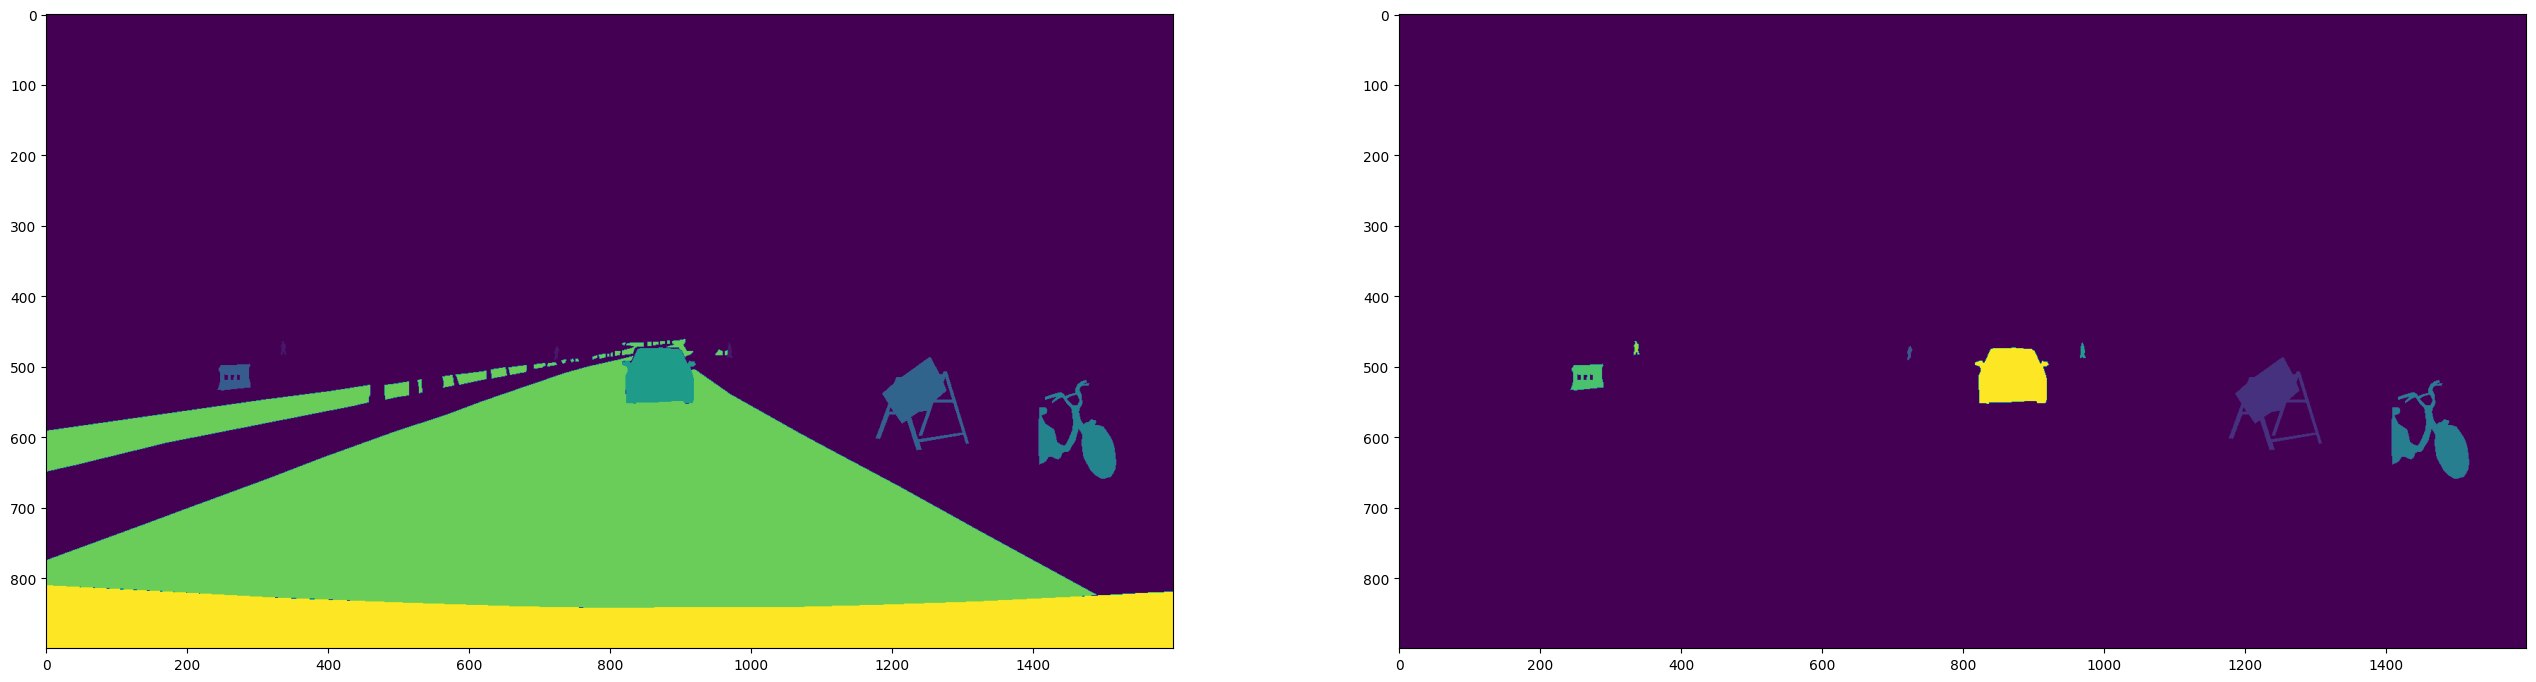

In [9]:
plt.figure(figsize=(32, 9))
plt.subplot(1, 2, 1)
plt.imshow(semantic_mask)
plt.subplot(1, 2, 2)
plt.imshow(instance_mask)

plt.show()

### Next, let's dive more into the image render function from the source code

In [10]:
def render_image(sample_data,dataroot,surface_ann,object_ann,
                     annotation_type: str = 'all',
                     with_category: bool = False,
                     with_attributes: bool = False,
                     object_tokens: List[str] = None,
                     surface_tokens: List[str] = None,
                     render_scale: float = 1.0,
                     box_line_width: int = -1,
                     font_size: int = None,
                     out_path: str = None) -> None:
        """
        Renders an image (sample_data), optionally with annotations overlaid.
        :param sd_token: The token of the sample_data to be rendered.
        :param annotation_type: The types of annotations to draw on the image; there are four options:
            'all': Draw surfaces and objects, subject to any filtering done by object_tokens and surface_tokens.
            'surfaces': Draw only surfaces, subject to any filtering done by surface_tokens.
            'objects': Draw objects, subject to any filtering done by object_tokens.
            'none': Neither surfaces nor objects will be drawn.
        :param with_category: Whether to include the category name at the top of a box.
        :param with_attributes: Whether to include attributes in the label tags. Note that with_attributes=True
            will only work if with_category=True.
        :param object_tokens: List of object annotation tokens. If given, only these annotations are drawn.
        :param surface_tokens: List of surface annotation tokens. If given, only these annotations are drawn.
        :param render_scale: The scale at which the image will be rendered. Use 1.0 for the original image size.
        :param box_line_width: The box line width in pixels. The default is -1.
            If set to -1, box_line_width equals render_scale (rounded) to be larger in larger images.
        :param font_size: Size of the text in the rendered image. Use None for the default size.
        :param out_path: The path where we save the rendered image, or otherwise None.
            If a path is provided, the plot is not shown to the user.
        """
        # Validate inputs.
        #sample_data = self.get('sample_data', sd_token)
        if not sample_data['is_key_frame']:
            assert annotation_type == 'none', 'Error: Cannot render annotations for non keyframes!'
            assert not with_attributes, 'Error: Cannot render attributes for non keyframes!'
        #if with_attributes:
        #    assert with_category, 'In order to set with_attributes=True, with_category must be True.'
        assert type(box_line_width) == int, 'Error: box_line_width must be an integer!'
        if box_line_width == -1:
            box_line_width = int(round(render_scale))

        # Get image data.
        #self.check_sweeps(sample_data['filename'])
        im_path = osp.join(dataroot, sample_data['filename'])
        im = Image.open(im_path)

        # Initialize drawing.
        if with_category and font_size != None:
            font = get_font(font_size=font_size)
        else:
            font = None
        im = im.convert('RGBA')
        draw = ImageDraw.Draw(im, 'RGBA') # RGBA mode(A for alpha(transparency))

        annotations_types = ['all', 'surfaces', 'objects', 'none']
        assert annotation_type in annotations_types, \
            'Error: {} is not a valid option for annotation_type. ' \
            'Only {} are allowed.'.format(annotation_type, annotations_types)
        if annotation_type != 'none':
            if annotation_type == 'all' or annotation_type == 'surfaces':
                # Load stuff / surface regions.
                surface_anns = [o for o in surface_ann if o['sample_data_token'] == sample_data['token']]
                #if surface_tokens is not None:
                #    sd_surface_tokens = set([s['token'] for s in surface_anns if s['token']])
                #    assert set(surface_tokens).issubset(sd_surface_tokens), \
                #        'Error: The provided surface_tokens do not belong to the sd_token!'
                #    surface_anns = [o for o in surface_anns if o['token'] in surface_tokens]

                # Draw stuff / surface regions.
                for ann in surface_anns:
                    # Get color and mask.
                    category_token = ann['category_token']
                    category_name = nuim.get('category', category_token)['name']
                    color = nuim.color_map[category_name]
                    if ann['mask'] is None:
                        continue
                    mask = mask_decode(ann['mask'])

                    # Draw mask. The label is obvious from the color.
                    draw.bitmap((0, 0), Image.fromarray(mask * 128), fill=tuple(color + (128,)))
                    # Draws a bitmap (mask) at the given position, using the current fill color for the non-zero portions. 
                    # The bitmap should be a valid transparency mask (mode “1”) or matte (mode “L” or “RGBA”).

            if annotation_type == 'all' or annotation_type == 'objects':
                # Load object instances.
                object_anns = [o for o in object_ann if o['sample_data_token'] == sample_data['token']]
                #if object_tokens is not None:
                #    sd_object_tokens = set([o['token'] for o in object_anns if o['token']])
                #    assert set(object_tokens).issubset(sd_object_tokens), \
                #        'Error: The provided object_tokens do not belong to the sd_token!'
                #    object_anns = [o for o in object_anns if o['token'] in object_tokens]

                # Draw object instances.
                for ann in object_anns:
                    # Get color, box, mask and name.
                    category_token = ann['category_token']
                    category_name = nuim.get('category', category_token)['name']
                    color = nuim.color_map[category_name]
                    bbox = ann['bbox']
                    attr_tokens = ann['attribute_tokens']
                    attributes = [nuim.get('attribute', at) for at in attr_tokens]
                    name = annotation_name(attributes, category_name, with_attributes=with_attributes)
                    if ann['mask'] is not None:
                        mask = mask_decode(ann['mask'])

                        # Draw mask, rectangle and text.
                        draw.bitmap((0, 0), Image.fromarray(mask * 128), fill=tuple(color + (128,)))
                        draw.rectangle(bbox, outline=color, width=box_line_width)
                        if with_category:
                            draw.text((bbox[0], bbox[1]), category_name, font=font)

        # Plot the image.
        (width, height) = im.size
        pix_to_inch = 100 / render_scale
        figsize = (height / pix_to_inch, width / pix_to_inch)
        plt.figure(figsize=figsize)
        plt.axis('off')
        plt.imshow(im)

        # Save to disk.
        if out_path is not None:
            plt.savefig(out_path, bbox_inches='tight', dpi=2.295 * pix_to_inch, pad_inches=0)
            plt.close()

Loaded 12 attribute(s) in 0.008s,


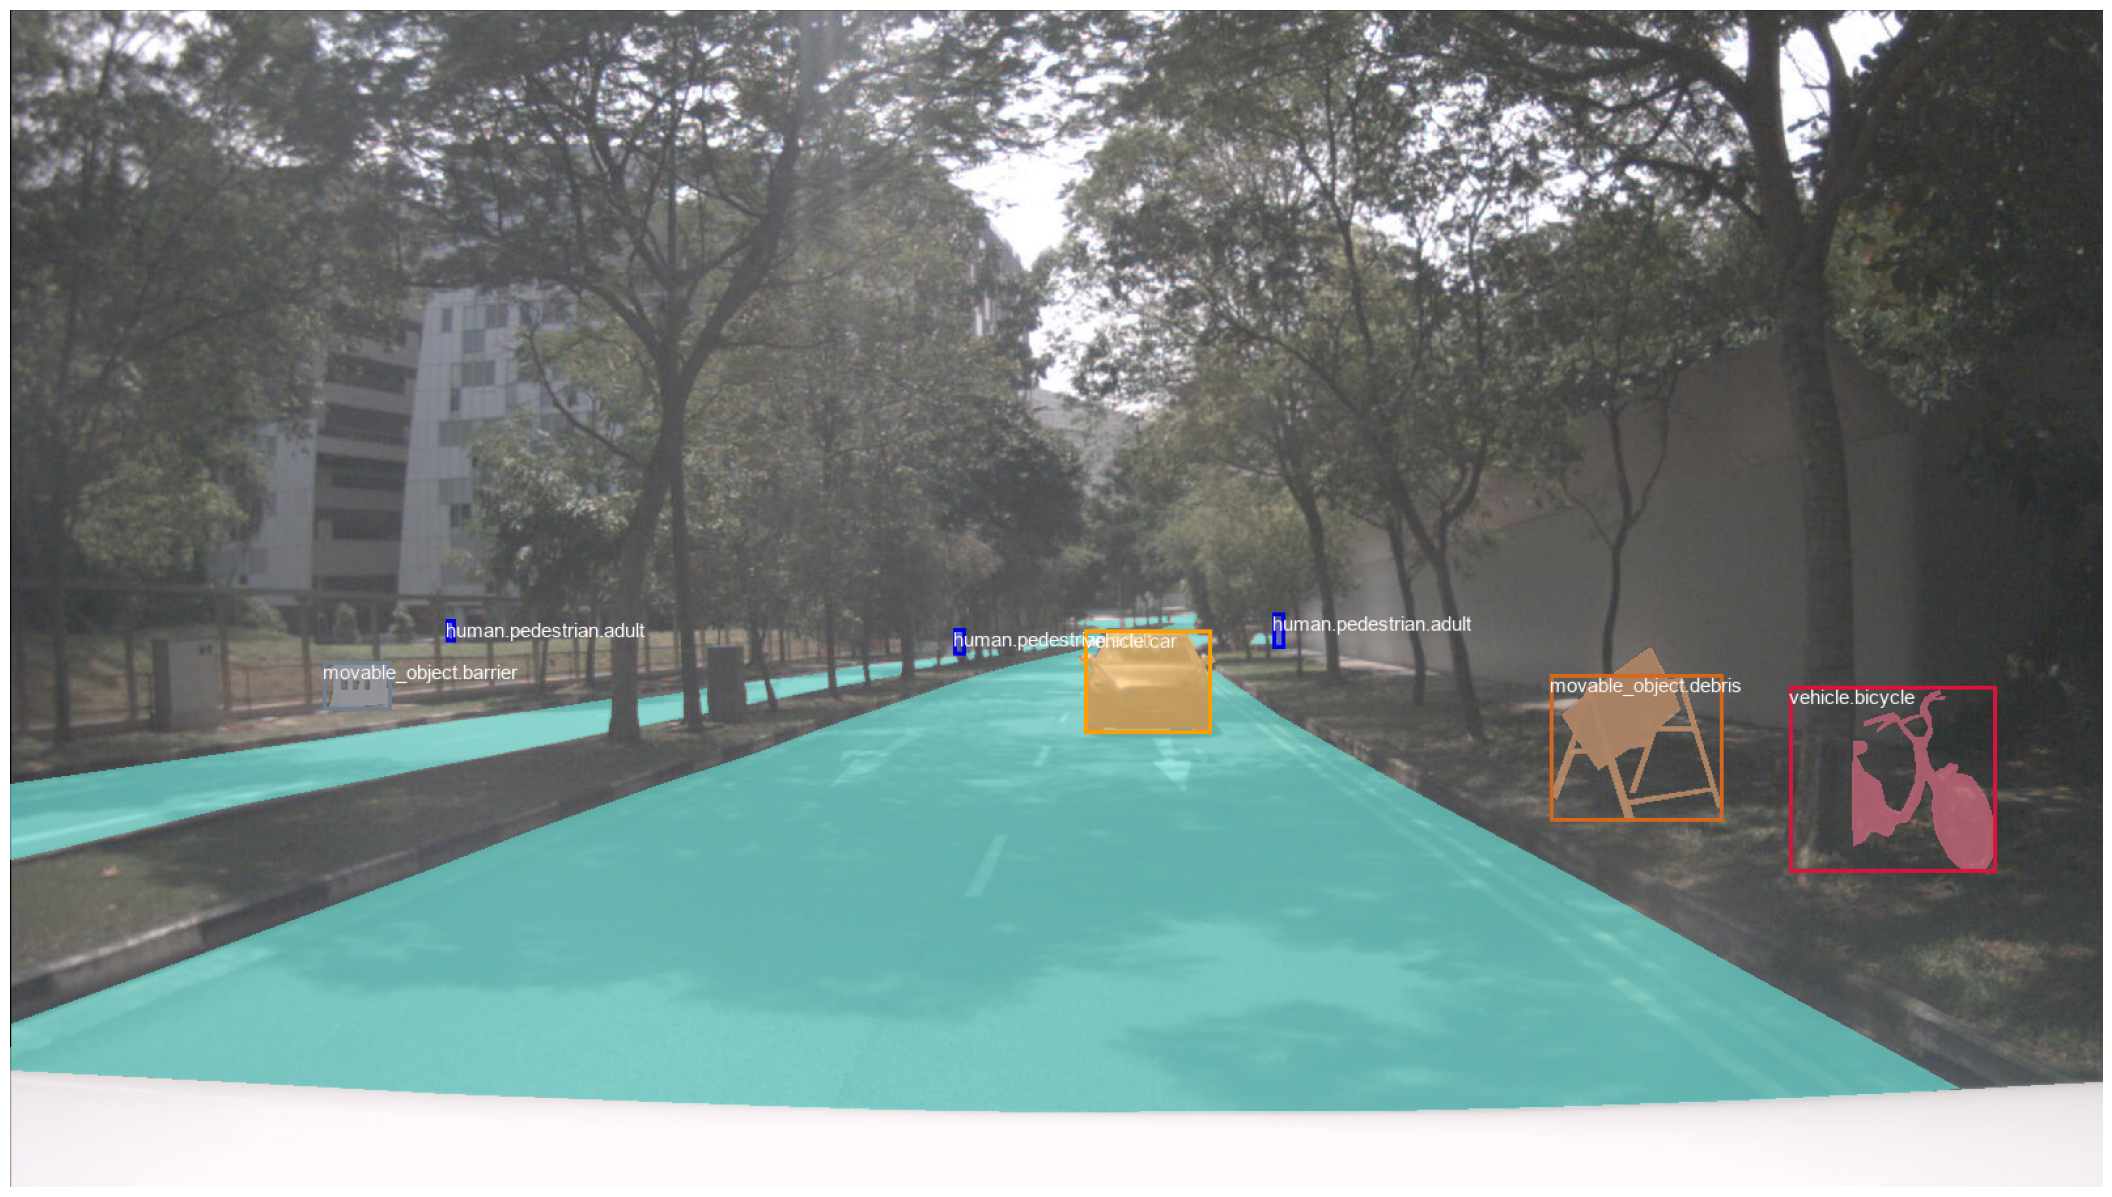

In [11]:
render_image(sample_data, dataroot, surface_ann, object_ann, with_category=True, with_attributes=True,font_size=15, render_scale=3)

### Next, the functions are modified to comply with test with customized data input to make sure the data input able to comply with COCO format.
The example of some COCO data formart are:
1. For Mask, either use `bitmap` or `plygon data` as standard input. So, will need to decode the Nuimage encoded mask to standard format.
2. For bounding box, it need a standard (Xmin, Ymin, Xmax, Ymax) format.

In [12]:
from pycocotools import mask #COCO API
from skimage import measure #for contour

In [13]:
def render_image_poly(sample_data,dataroot,surface_ann,object_ann,
                     annotation_type: str = 'all',
                     with_category: bool = False,
                     with_attributes: bool = False,
                     object_tokens: List[str] = None,
                     surface_tokens: List[str] = None,
                     render_scale: float = 1.0,
                     box_line_width: int = -1,
                     font_size: int = None,
                     out_path: str = None) -> None:

        # Validate inputs.
        #sample_data = self.get('sample_data', sd_token)
        if not sample_data['is_key_frame']:
            assert annotation_type == 'none', 'Error: Cannot render annotations for non keyframes!'
            assert not with_attributes, 'Error: Cannot render attributes for non keyframes!'
        #if with_attributes:
        #    assert with_category, 'In order to set with_attributes=True, with_category must be True.'
        assert type(box_line_width) == int, 'Error: box_line_width must be an integer!'
        if box_line_width == -1:
            box_line_width = int(round(render_scale))

        # Get image data.
        #self.check_sweeps(sample_data['filename'])
        im_path = osp.join(dataroot, sample_data['filename'])
        im = Image.open(im_path)

        # Initialize drawing.
        if with_category and font_size != None:
            font = get_font(font_size=font_size)
        else:
            font = None
        im = im.convert('RGBA')
        draw = ImageDraw.Draw(im, 'RGBA') # RGBA mode(A for alpha(transparency))

        annotations_types = ['all', 'surfaces', 'objects', 'none']
        assert annotation_type in annotations_types, \
            'Error: {} is not a valid option for annotation_type. ' \
            'Only {} are allowed.'.format(annotation_type, annotations_types)
        if annotation_type != 'none':
            if annotation_type == 'all' or annotation_type == 'surfaces':
                # Load stuff / surface regions.
                surface_anns = [o for o in surface_ann if o['sample_data_token'] == sample_data['token']]

                # Draw stuff / surface regions.
                for ann in surface_anns:
                    # Get color and mask.
                    category_token = ann['category_token']
                    category_name = nuim.get('category', category_token)['name']
                    color = nuim.color_map[category_name]
                    if ann['mask'] is None:
                        continue
                    mask = mask_decode(ann['mask'])  #decode the mask
                    mask_list = np.ascontiguousarray(mask , dtype=np.uint8)
                    contours = measure.find_contours(mask_list, 0.5) #find the contours of the mask
                    for contour in contours:
                        contour = np.flip(contour, axis=1)
                        #contour *= render_scale
                        contour = [tuple(p) for p in contour]
                        draw.polygon(contour, fill=tuple(color + (128,)), outline=tuple(color+(128,))) #draw the contour


            if annotation_type == 'all' or annotation_type == 'objects':
                # Load object instances.
                object_anns = [o for o in object_ann if o['sample_data_token'] == sample_data['token']]

                # Draw object instances.
                for ann in object_anns:
                    # Get color, box, mask and name.
                    category_token = ann['category_token']
                    category_name = nuim.get('category', category_token)['name']
                    color = nuim.color_map[category_name]
                    bbox = ann['bbox']
                    attr_tokens = ann['attribute_tokens']
                    attributes = [nuim.get('attribute', at) for at in attr_tokens]
                    name = annotation_name(attributes, category_name, with_attributes=with_attributes)
                    if ann['mask'] is not None:
                        mask = mask_decode(ann['mask'])
                        mask_list = np.ascontiguousarray(mask , dtype=np.uint8)
                        contours = measure.find_contours(mask_list, 0.5)
                        for contour in contours:
                          contour = np.flip(contour, axis=1)
                          #contour *= render_scale
                          contour = [tuple(p) for p in contour]
                          draw.polygon(contour,fill=tuple(color + (128,)), outline=tuple(color+(128,))) #draw the contour

                        draw.rectangle(bbox, outline=color, width=box_line_width)
                        if with_category:
                            draw.text((bbox[0], bbox[1]), category_name, font=font)

        # Plot the image.
        (width, height) = im.size
        pix_to_inch = 100 / render_scale
        figsize = (height / pix_to_inch, width / pix_to_inch)
        plt.figure(figsize=figsize)
        plt.axis('off')
        plt.imshow(im)

        # Save to disk.
        if out_path is not None:
            plt.savefig(out_path, bbox_inches='tight', dpi=2.295 * pix_to_inch, pad_inches=0)
            plt.close()

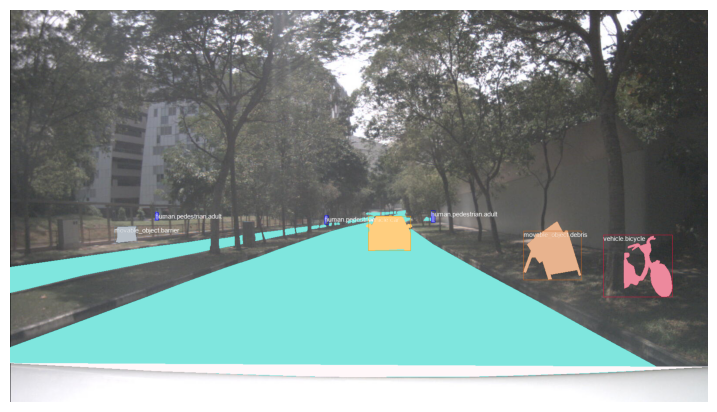

In [14]:
render_image_poly(sample_data, dataroot, surface_ann, object_ann, with_category=True, with_attributes=True,font_size=15, render_scale=1)

By decoding the mask file and convert it into `polygon` coordinate point, it is still prefectly fit with the original object image contour.

### Combine bounding box and instance mask for every single labelled object

In [16]:
##preprocess to COCO annotation format from bitmap into polygon data coordinates

ground_truth_binary_mask = np.array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
                                     [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
                                     [  0,   0,   0,   0,   0,   1,   1,   1,   0,   0],
                                     [  0,   0,   0,   0,   0,   1,   1,   1,   0,   0],
                                     [  0,   0,   0,   0,   0,   1,   1,   1,   0,   0],
                                     [  0,   0,   0,   0,   0,   1,   1,   1,   0,   0],
                                     [  1,   0,   0,   0,   0,   0,   0,   0,   0,   0],
                                     [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
                                     [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0]])
mask_list = np.ascontiguousarray(ground_truth_binary_mask , dtype=np.uint8)
contours = measure.find_contours(mask_list, 0.5)
test = []
for contour in contours:
    contour = np.flip(contour, axis=1)
    contour = [tuple(p) for p in contour]
    test.append([p for x in contour for p in x])
    
print(test)

[[7.0, 5.5, 6.0, 5.5, 5.0, 5.5, 4.5, 5.0, 4.5, 4.0, 4.5, 3.0, 4.5, 2.0, 5.0, 1.5, 6.0, 1.5, 7.0, 1.5, 7.5, 2.0, 7.5, 3.0, 7.5, 4.0, 7.5, 5.0, 7.0, 5.5], [0.0, 5.5, 0.5, 6.0, 0.0, 6.5]]


In [17]:
# Combination of bounding box and instance Mask

def render_image_combine(sample_data,dataroot,surface_ann,object_ann,
                     annotation_type: str = 'all',
                     with_category: bool = False,
                     with_attributes: bool = False,
                     object_tokens: List[str] = None,
                     surface_tokens: List[str] = None,
                     render_scale: float = 1.0,
                     box_line_width: int = -1,
                     font_size: int = None,
                     out_path: str = None) -> None:

        # Validate inputs.

        if not sample_data['is_key_frame']:
            assert annotation_type == 'none', 'Error: Cannot render annotations for non keyframes!'
            assert not with_attributes, 'Error: Cannot render attributes for non keyframes!'

        #if with_attributes:
        #    assert with_category, 'In order to set with_attributes=True, with_category must be True.'
        assert type(box_line_width) == int, 'Error: box_line_width must be an integer!'
        if box_line_width == -1:
            box_line_width = int(round(render_scale))

        # Get image data.
        #self.check_sweeps(sample_data['filename'])
        im_path = osp.join(dataroot, sample_data['filename'])
        print(im_path)
        im = Image.open(im_path)

        # Initialize drawing.
        if with_category and font_size != None:
            font = get_font(font_size=font_size)
        else:
            font = None
        im = im.convert('RGBA')
        draw = ImageDraw.Draw(im, 'RGBA') # RGBA mode(A for alpha(transparency))

        annotations_types = ['all', 'surfaces', 'objects', 'none']
        assert annotation_type in annotations_types, \
            'Error: {} is not a valid option for annotation_type. ' \
            'Only {} are allowed.'.format(annotation_type, annotations_types)
        if annotation_type != 'none':
            if annotation_type == 'all' or annotation_type == 'surfaces':
                # Load stuff / surface regions.
                surface_anns = [o for o in surface_ann if o['sample_data_token'] == sample_data['token']]

                # Draw stuff / surface regions.
                for ann in surface_anns:
                    # Get color and mask.
                    category_token = ann['category_token']
                    category_name = nuim.get('category', category_token)['name']
                    color = nuim.color_map[category_name]
                    if ann['mask'] is None:
                        continue
                    mask = mask_decode(ann['mask'])
                    mask_list = np.ascontiguousarray(mask , dtype=np.uint8)
                    contours = measure.find_contours(mask_list, 0.5)
                    px = []
                    py = []
                    for contour in contours:
                        contour = np.flip(contour, axis=1)
                        px = contour[:,0]  # x coordinates of pixels inside the object
                        py = contour[:,1] # y coordinates of pixels inside the object
                        
                        contour = [tuple(p) for p in contour]
                        draw.polygon(contour, fill=tuple(color + (128,)), outline=tuple(color+(128,)))
                        bbox = [np.min(px), np.min(py), np.max(px), np.max(py)] # x1, y1, x2, y2
                        draw.rectangle(bbox, outline=color, width=1)            # draw bounding box


            if annotation_type == 'all' or annotation_type == 'objects':
                # Load object instances.
                object_anns = [o for o in object_ann if o['sample_data_token'] == sample_data['token']]

                # Draw object instances.
                for ann in object_anns:
                    # Get color, box, mask and name.
                    category_token = ann['category_token']
                    category_name = nuim.get('category', category_token)['name']
                    color = nuim.color_map[category_name]
                    bbox = ann['bbox']

                    if ann['mask'] is not None:
                        mask = mask_decode(ann['mask'])
                        mask_list = np.ascontiguousarray(mask , dtype=np.uint8)
                        contours = measure.find_contours(mask_list, 0.5)
                        for contour in contours:
                          contour = np.flip(contour, axis=1)
                    #      #contour *= render_scale
                          contour = [tuple(p) for p in contour]
                          draw.polygon(contour,fill=tuple(color + (128,)), outline=tuple(color+(128,)))

                        # Draw mask, rectangle and text.
                    draw.rectangle(bbox, outline=color, width=box_line_width)
                    if with_category:
                           draw.text((bbox[0], bbox[1]), category_name, font=font)

        # Plot the image.
        (width, height) = im.size
        pix_to_inch = 100 / render_scale
        figsize = (height / pix_to_inch, width / pix_to_inch)
        plt.figure(figsize=figsize)
        plt.axis('off')
        plt.imshow(im)

        # Save to disk.
        if out_path is not None:
            plt.savefig(out_path, bbox_inches='tight', dpi=2.295 * pix_to_inch, pad_inches=0)
            plt.close()

C:/Users/pkfei/OneDrive/Desktop/Capstone/data/sample\samples/CAM_BACK/n013-2018-08-29-11-41-15+0800__CAM_BACK__1535514187537005.jpg


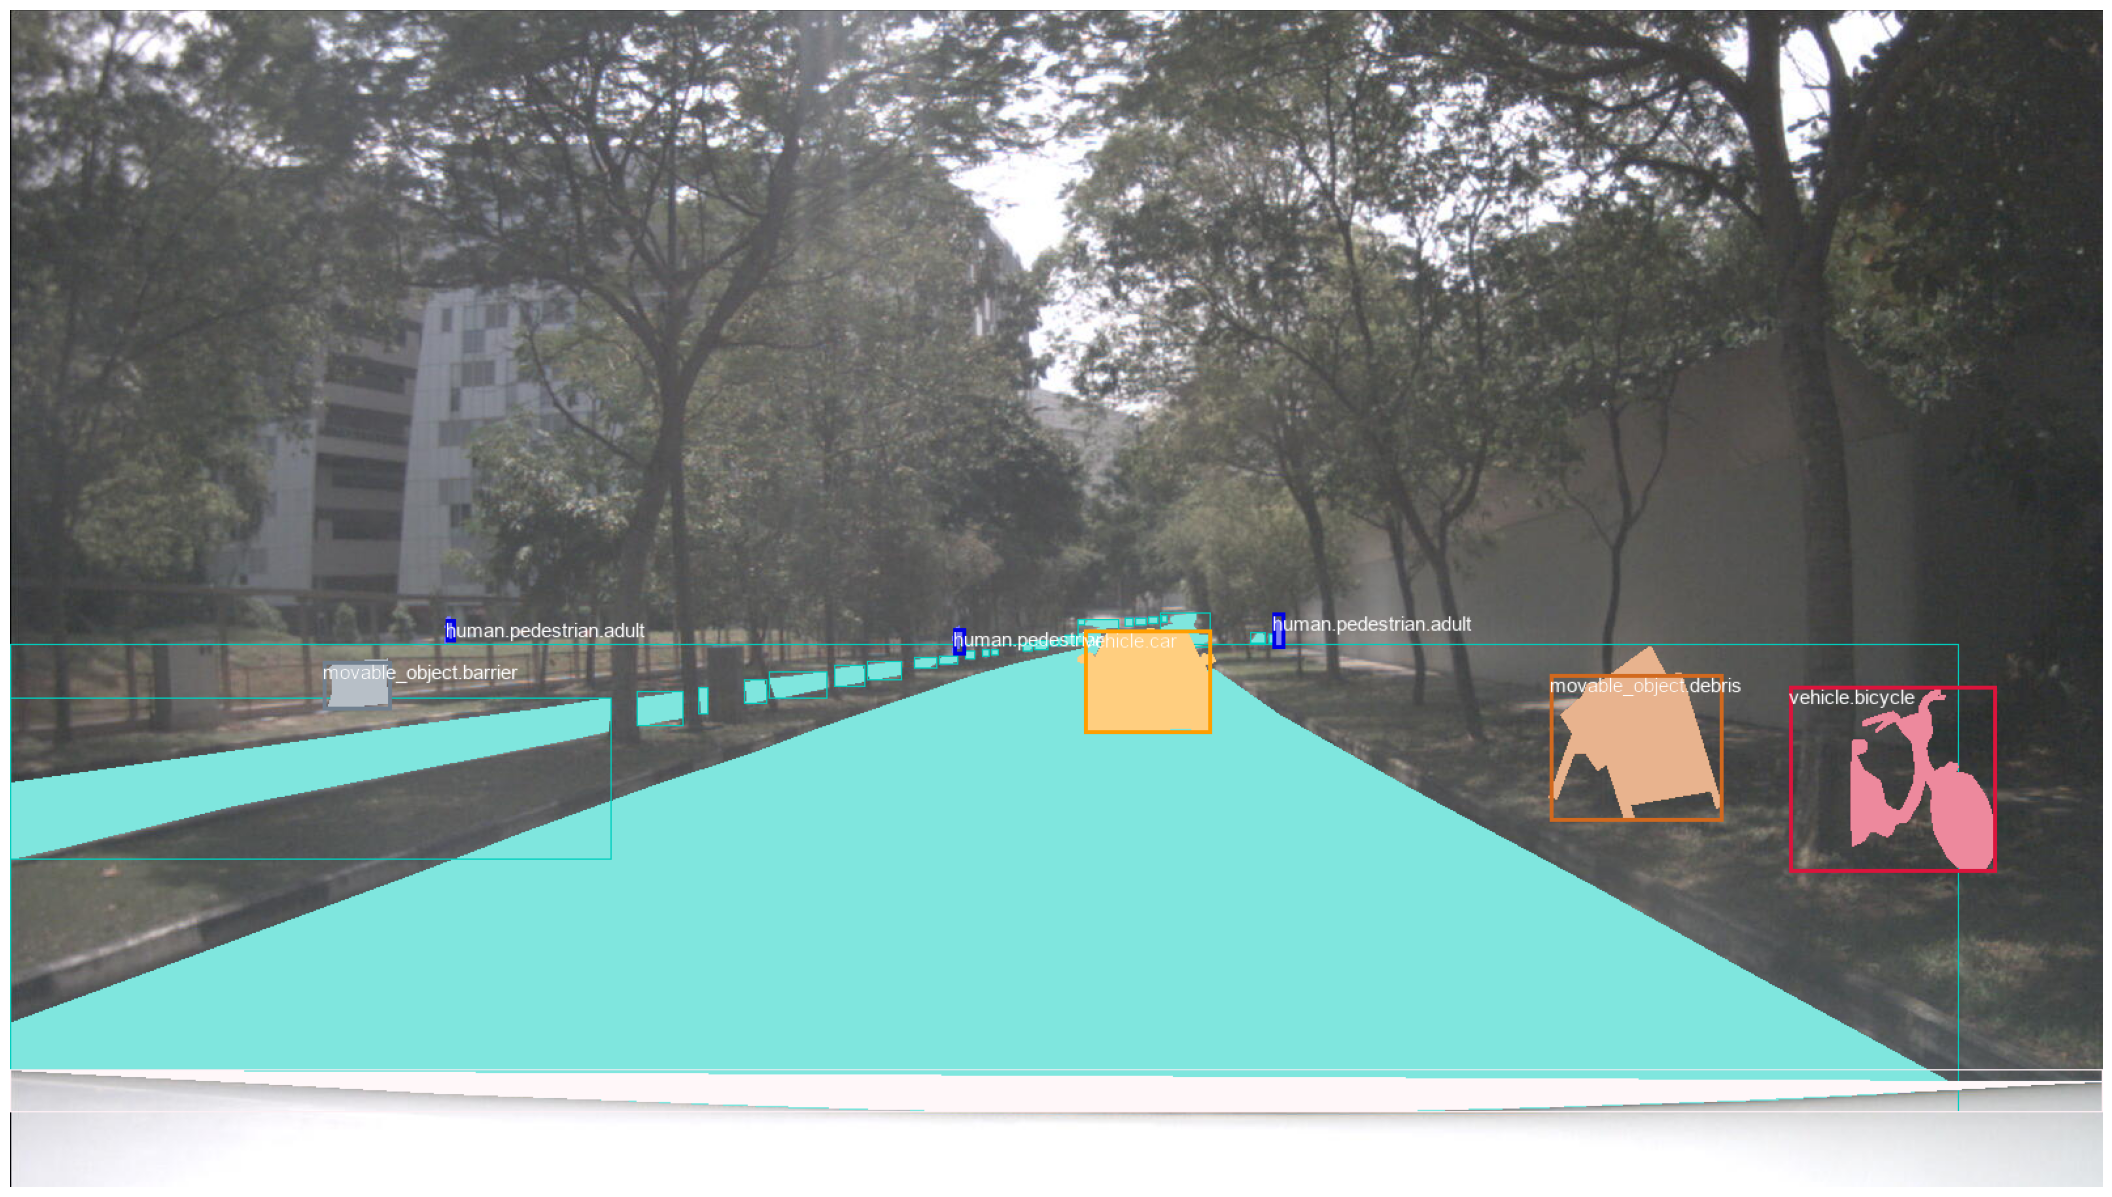

In [18]:
render_image_combine(sample_data, dataroot, surface_ann, object_ann, with_category=True, with_attributes=True,font_size=15, render_scale=3)

### Key Take-away

- The default structures of the data from `nuImages` are able to be broken down and converted into the format that fit in the COCO annotation file input.
- The key steps is deccoding the encoded Mask file into Bitmap and then further convert it into polygon data point. 
- Since the bounding box is not defined for the surface annotations, the bounding box for the label can be calculated manually.


The next section, there will be combining of datasets and multiple feature engineering steps to prepare the data to train